In [2]:
import logging

logging.basicConfig(level=logging.INFO)
import json
from itertools import combinations

import eo_tools
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import shapely
from eo_tools.S1.process import process_insar
from eodag import EODataAccessGateway
from shapely.geometry import shape

dag = EODataAccessGateway()
# make sure cop_dataspace will be used
dag.set_preferred_provider("cop_dataspace")
logging.basicConfig(level=logging.INFO)

INFO:eodag.config:Loading user configuration from: /home/al/.config/eodag/eodag.yml
INFO:eodag.core:usgs: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:aws_eos: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:meteoblue: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:hydroweb_next: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:wekeo: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:creodias_s3: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:Locations configuration loaded from /home/al/.config/eodag/locations.yml


In [10]:
# Run search

bbox = {
    "lonmin": 0.08905898091569497,
    "latmin": 52.15527412683906,
    "lonmax": 0.9565339502005088,
    "latmax": 52.69722175598818,
}
shp = shapely.box(bbox["lonmin"], bbox["latmin"], bbox["lonmax"], bbox["latmax"])

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2023-09-03",
    "end": "2023-09-17",
    "geom": bbox,
}

results, _ = dag.search(**search_criteria)

# Find overlaps
data = []
for item in results:
    id = item.properties["id"]
    geom = shape(item.geometry)
    data.append({"id": id, "geometry": geom})

gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")  # Assuming WGS84

# 98% overlap
threshold = 0.98

overlaps = []
for (idx1, row1), (idx2, row2) in combinations(gdf.iterrows(), 2):
    intersection = row1["geometry"].intersection(row2["geometry"])
    if not intersection.is_empty:
        # Calculate overlap ratio as the area of intersection divided by the area of the smaller polygon
        overlap_ratio = intersection.area / min(
            row1["geometry"].area, row2["geometry"].area
        )
        if overlap_ratio >= threshold:
            overlaps.append((row1["id"], row2["id"], overlap_ratio))

overlap_ids = [entry[:-1] for entry in overlaps]
overlap_ids

INFO:eodag.core:Searching product type 'S1_SAR_SLC' on provider: cop_dataspace
INFO:eodag.search.qssearch:Sending search request: http://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel1/search.json?startDate=2023-09-03&completionDate=2023-09-17&geometry=POLYGON ((0.0891 52.1553, 0.0891 52.6972, 0.9565 52.6972, 0.9565 52.1553, 0.0891 52.1553))&productType=SLC&maxRecords=20&page=1&exactCount=1
INFO:eodag.core:Found 7 result(s) on provider 'cop_dataspace'


[('S1A_IW_SLC__1SDV_20230904T174209_20230904T174236_050181_060A2D_E88F',
  'S1A_IW_SLC__1SDV_20230916T174209_20230916T174236_050356_061016_8033'),
 ('S1A_IW_SLC__1SDV_20230904T174144_20230904T174211_050181_060A2D_46E8',
  'S1A_IW_SLC__1SDV_20230916T174145_20230916T174212_050356_061016_9D13')]

In [11]:
# Set download dirs
data_dir = "/home/al/Downloads/eotools"

ids = [
    "S1A_IW_SLC__1SDV_20241016T174206_20241016T174233_056131_06DE72_1B0C",
    "S1A_IW_SLC__1SDV_20241028T174206_20241028T174233_056306_06E564_F046"
]
    #"S1A_IW_SLC__1SDV_20230904T174209_20230904T174236_050181_060A2D_E88F",
    #"S1A_IW_SLC__1SDV_20230916T174209_20230916T174236_050356_061016_8033",
#]

primary_dir = f"{data_dir}/{ids[0]}.zip"
secondary_dir = f"{data_dir}/{ids[1]}.zip"
outputs_prefix = f"{data_dir}/res/test-full-processor"

In [12]:
# AOI around Thetford
file_aoi = f"{data_dir}/thetfordaoi.geojson"
shp2 = gpd.read_file(file_aoi).geometry[0]

In [10]:
# Download overlapping products
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
dag.download_all(to_dl, outputs_prefix=data_dir, extract=False)

INFO:eodag.core:Downloading 2 products


2 products to download


Downloaded products:   0%|          | 0/2 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

INFO:eodag.download.base:Download url: https://catalogue.dataspace.copernicus.eu/odata/v1/Products(560dc4f0-4661-4ff5-a7e2-3c2280c87c81)/$value
INFO:eodag.download.base:Product already downloaded: /home/figi/software/work/eodh/user-workflows/test-1/data/S1A_IW_SLC__1SDV_20230904T174209_20230904T174236_050181_060A2D_E88F.zip
INFO:eodag.download.base:Extraction not activated. The product is available as is.
INFO:eodag.product:Remote location of the product is still available through its 'remote_location' property: https://catalogue.dataspace.copernicus.eu/odata/v1/Products(560dc4f0-4661-4ff5-a7e2-3c2280c87c81)/$value


0.00B [00:00, ?B/s]

INFO:eodag.download.base:Download url: https://catalogue.dataspace.copernicus.eu/odata/v1/Products(a283b833-9652-4746-a7ff-5a33ef70b755)/$value
INFO:eodag.download.base:Product already downloaded: /home/figi/software/work/eodh/user-workflows/test-1/data/S1A_IW_SLC__1SDV_20230916T174209_20230916T174236_050356_061016_8033.zip
INFO:eodag.download.base:Extraction not activated. The product is available as is.
INFO:eodag.product:Remote location of the product is still available through its 'remote_location' property: https://catalogue.dataspace.copernicus.eu/odata/v1/Products(a283b833-9652-4746-a7ff-5a33ef70b755)/$value


['/home/figi/software/work/eodh/user-workflows/test-1/data/S1A_IW_SLC__1SDV_20230904T174209_20230904T174236_050181_060A2D_E88F.zip',
 '/home/figi/software/work/eodh/user-workflows/test-1/data/S1A_IW_SLC__1SDV_20230916T174209_20230916T174236_050356_061016_8033.zip']

In [13]:
eo_tools.util.explore_products(results, shp2)

In [14]:
out_dir = process_insar(
    dir_prm=primary_dir,
    dir_sec=secondary_dir,
    outputs_prefix=outputs_prefix,
    aoi_name=None,
    shp=shp2,
    pol="vv",
    subswaths=["IW1", "IW2", "IW3"],
    write_coherence=True,
    write_interferogram=True,
    write_primary_amplitude=False,
    write_secondary_amplitude=False,
    apply_fast_esd=True,
    dem_upsampling=1.8,
    dem_force_download=False,
    dem_buffer_arc_sec=40,
    boxcar_coherence=[3, 3],
    filter_ifg=True,
    multilook=[1, 4],
    warp_kernel="bicubic",
    clip_to_shape=True,
)

INFO:eo_tools.S1.process:---- Processing subswath IW1 in VV polarization
INFO:eo_tools.S1.core:S1IWSwath Initialization:
INFO:eo_tools.S1.core:- Read metadata file /home/al/Downloads/eotools/S1A_IW_SLC__1SDV_20241016T174206_20241016T174233_056131_06DE72_1B0C.zip/S1A_IW_SLC__1SDV_20241016T174206_20241016T174233_056131_06DE72_1B0C.SAFE/annotation/s1a-iw1-slc-vv-20241016t174207-20241016t174232-056131-06de72-004.xml
INFO:eo_tools.S1.core:- Read calibration file /home/al/Downloads/eotools/S1A_IW_SLC__1SDV_20241016T174206_20241016T174233_056131_06DE72_1B0C.zip/S1A_IW_SLC__1SDV_20241016T174206_20241016T174233_056131_06DE72_1B0C.SAFE/annotation/calibration/calibration-s1a-iw1-slc-vv-20241016t174207-20241016t174232-056131-06de72-004.xml
INFO:eo_tools.S1.core:- Set up raster path zip:///home/al/Downloads/eotools/S1A_IW_SLC__1SDV_20241016T174206_20241016T174233_056131_06DE72_1B0C.zip/S1A_IW_SLC__1SDV_20241016T174206_20241016T174233_056131_06DE72_1B0C.SAFE/measurement/s1a-iw1-slc-vv-20241016t17420

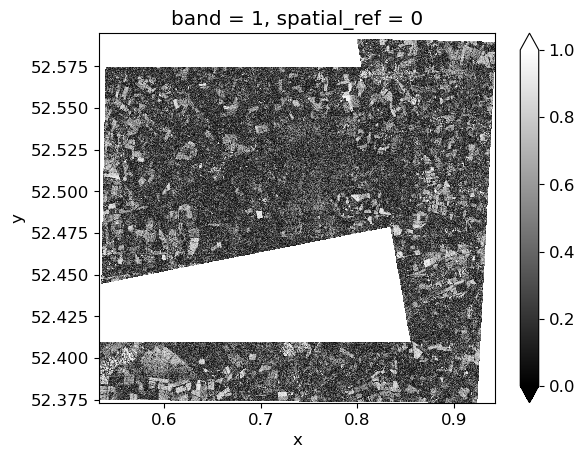

In [8]:
# Visualise coherence
arr_coh = riox.open_rasterio(f"{out_dir}/coh_vv.tif", masked=True)[0]
arr_coh.plot.imshow(vmin=0,vmax=1, cmap="gray")

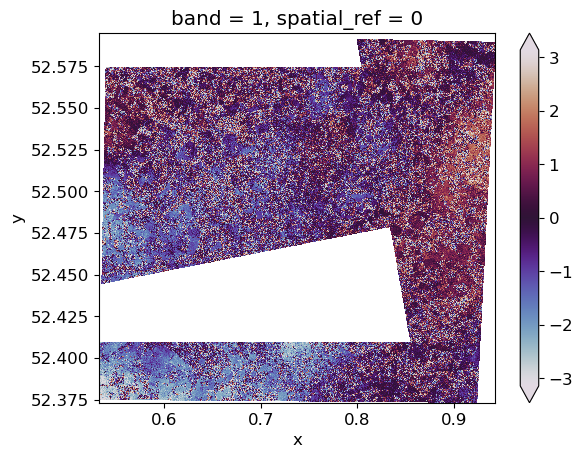

In [9]:
# Visualise interferrogram
arr_phi = riox.open_rasterio(f"{out_dir}/phi_vv.tif", masked=True)[0]
arr_phi.plot.imshow(vmin=-3.14,vmax=3.14, cmap="twilight")

# Get DEM
Doesn't need to be in workflow

In [15]:
from eo_tools.dem import retrieve_dem

In [17]:
# load a geometry
aoi_name = "thetford2aoi"
file_aoi = f"{data_dir}/{aoi_name}.geojson"
shp = gpd.read_file(file_aoi).geometry[0]
# change to your custom location
dem_file = f"{data_dir}/res/cop-dem-glo-30_{aoi_name}.tif"
retrieve_dem(shp, dem_file)

INFO:eo_tools.dem:Retrieve DEM
